# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [54]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

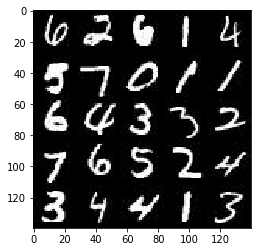

In [55]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

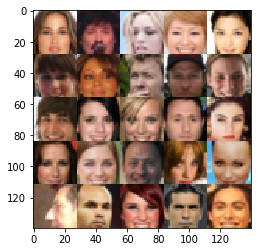

In [56]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [58]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_shape = (None, image_width, image_height, image_channels)
    real_inps = tf.placeholder(dtype=tf.float32, shape= real_shape, name="real_inputs")
    z_inps = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="z_inputs")
    lr = tf.placeholder(dtype=tf.float32, shape=(None), name="learning_rate")

    return real_inps, z_inps, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [59]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Reference: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [60]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        # Firsh fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [61]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real,     dis_logits_real = discriminator(input_real)
    dis_model_fake,     dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_real, labels=tf.ones_like(dis_model_real)
        )
    )
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)
        )
    )
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [62]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dis_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    return dis_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [64]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, channels)
    dis_opt, gen_opt = model_opt(dis_loss, gen_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(dis_opt, feed_dict={input_real: batch_images, input_z: z_batch, learn_rate: learning_rate})
                _ = sess.run(gen_opt, feed_dict={input_real: batch_images, input_z: z_batch, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_dis = dis_loss.eval({input_z: z_batch, input_real: batch_images})
                    train_loss_gen = gen_loss.eval({input_z: z_batch})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_dis),
                          "Generator Loss: {:.4f}".format(train_loss_gen))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 4.7204... Generator Loss: 0.0161
Epoch 0/2... Discriminator Loss: 2.2480... Generator Loss: 3.9956
Epoch 0/2... Discriminator Loss: 1.4750... Generator Loss: 0.4795
Epoch 0/2... Discriminator Loss: 0.9222... Generator Loss: 1.1019


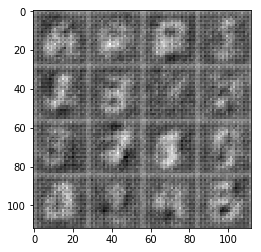

Epoch 0/2... Discriminator Loss: 0.8025... Generator Loss: 2.6895
Epoch 0/2... Discriminator Loss: 0.6921... Generator Loss: 1.4406
Epoch 0/2... Discriminator Loss: 1.0689... Generator Loss: 3.0684
Epoch 0/2... Discriminator Loss: 0.5759... Generator Loss: 1.4528
Epoch 0/2... Discriminator Loss: 2.5529... Generator Loss: 0.1239


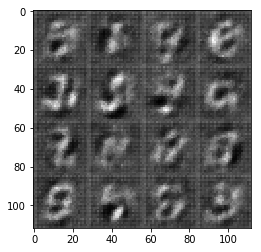

Epoch 0/2... Discriminator Loss: 0.3675... Generator Loss: 1.8698
Epoch 0/2... Discriminator Loss: 0.2684... Generator Loss: 2.1041
Epoch 0/2... Discriminator Loss: 0.2649... Generator Loss: 1.7568
Epoch 0/2... Discriminator Loss: 0.1447... Generator Loss: 2.4508
Epoch 0/2... Discriminator Loss: 0.1273... Generator Loss: 2.6319


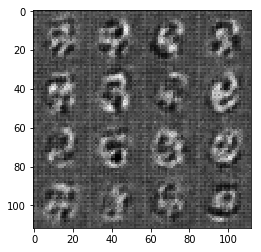

Epoch 0/2... Discriminator Loss: 1.0181... Generator Loss: 0.5241
Epoch 0/2... Discriminator Loss: 0.8404... Generator Loss: 0.9640
Epoch 0/2... Discriminator Loss: 0.5159... Generator Loss: 1.5270
Epoch 0/2... Discriminator Loss: 0.4657... Generator Loss: 1.3263
Epoch 0/2... Discriminator Loss: 0.5927... Generator Loss: 4.5880


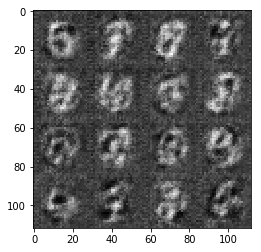

Epoch 0/2... Discriminator Loss: 0.4946... Generator Loss: 1.4583
Epoch 0/2... Discriminator Loss: 1.2136... Generator Loss: 0.5154
Epoch 0/2... Discriminator Loss: 0.7043... Generator Loss: 0.9305
Epoch 0/2... Discriminator Loss: 0.0677... Generator Loss: 5.0261
Epoch 0/2... Discriminator Loss: 0.1052... Generator Loss: 4.1339


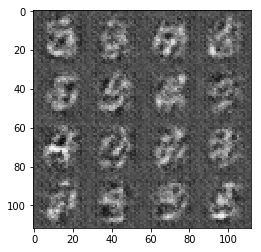

Epoch 0/2... Discriminator Loss: 2.2234... Generator Loss: 5.5829
Epoch 0/2... Discriminator Loss: 0.5221... Generator Loss: 1.3945
Epoch 0/2... Discriminator Loss: 0.3142... Generator Loss: 1.6797
Epoch 0/2... Discriminator Loss: 0.2856... Generator Loss: 1.7204
Epoch 0/2... Discriminator Loss: 0.2475... Generator Loss: 3.2590


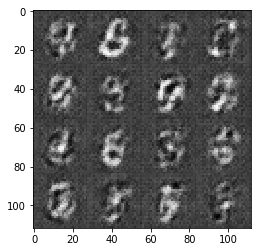

Epoch 0/2... Discriminator Loss: 0.1349... Generator Loss: 2.8166
Epoch 0/2... Discriminator Loss: 0.0943... Generator Loss: 3.5905
Epoch 0/2... Discriminator Loss: 0.8721... Generator Loss: 0.7089
Epoch 0/2... Discriminator Loss: 0.3485... Generator Loss: 1.8282
Epoch 0/2... Discriminator Loss: 0.2565... Generator Loss: 2.2450


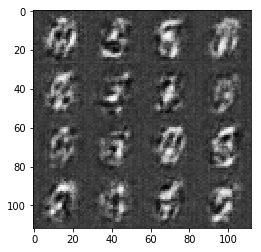

Epoch 0/2... Discriminator Loss: 0.3986... Generator Loss: 1.4709
Epoch 0/2... Discriminator Loss: 0.2219... Generator Loss: 2.1718
Epoch 0/2... Discriminator Loss: 0.2298... Generator Loss: 2.1107
Epoch 0/2... Discriminator Loss: 0.1980... Generator Loss: 2.1727
Epoch 0/2... Discriminator Loss: 0.2539... Generator Loss: 1.8826


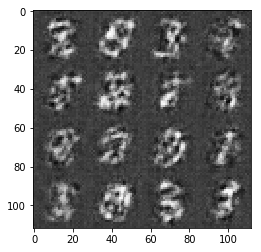

Epoch 0/2... Discriminator Loss: 0.2016... Generator Loss: 2.1775
Epoch 0/2... Discriminator Loss: 0.1254... Generator Loss: 2.9133
Epoch 0/2... Discriminator Loss: 0.1706... Generator Loss: 2.4531
Epoch 0/2... Discriminator Loss: 0.1482... Generator Loss: 2.5602
Epoch 0/2... Discriminator Loss: 3.5059... Generator Loss: 9.6070


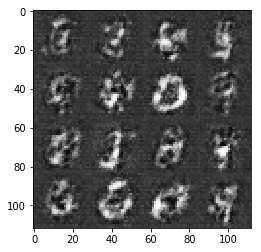

Epoch 0/2... Discriminator Loss: 0.9369... Generator Loss: 1.7707
Epoch 0/2... Discriminator Loss: 0.6432... Generator Loss: 1.3880
Epoch 0/2... Discriminator Loss: 0.5293... Generator Loss: 1.4324
Epoch 0/2... Discriminator Loss: 0.4078... Generator Loss: 1.5848
Epoch 0/2... Discriminator Loss: 0.3555... Generator Loss: 1.7668


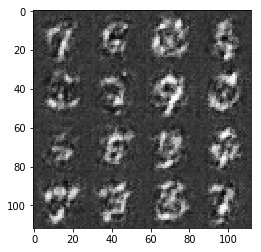

Epoch 0/2... Discriminator Loss: 0.2253... Generator Loss: 2.4750
Epoch 0/2... Discriminator Loss: 0.1610... Generator Loss: 2.5560
Epoch 0/2... Discriminator Loss: 0.1849... Generator Loss: 2.1430
Epoch 0/2... Discriminator Loss: 0.1566... Generator Loss: 2.5681
Epoch 0/2... Discriminator Loss: 0.1550... Generator Loss: 2.3734


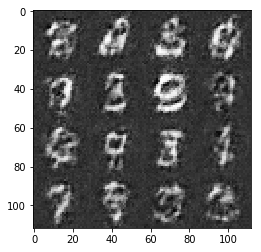

Epoch 0/2... Discriminator Loss: 0.1279... Generator Loss: 2.7433
Epoch 0/2... Discriminator Loss: 0.2288... Generator Loss: 1.8670
Epoch 0/2... Discriminator Loss: 0.1367... Generator Loss: 2.3292
Epoch 0/2... Discriminator Loss: 0.1240... Generator Loss: 2.7110
Epoch 0/2... Discriminator Loss: 0.1376... Generator Loss: 2.5403


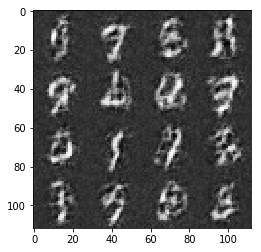

Epoch 0/2... Discriminator Loss: 0.2074... Generator Loss: 1.9693
Epoch 0/2... Discriminator Loss: 0.0691... Generator Loss: 3.5593
Epoch 0/2... Discriminator Loss: 0.0936... Generator Loss: 3.1896
Epoch 0/2... Discriminator Loss: 0.0737... Generator Loss: 3.2766
Epoch 0/2... Discriminator Loss: 0.2517... Generator Loss: 1.8359


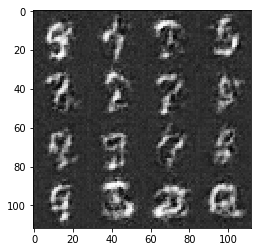

Epoch 0/2... Discriminator Loss: 0.1870... Generator Loss: 2.1565
Epoch 0/2... Discriminator Loss: 0.1230... Generator Loss: 2.5964
Epoch 0/2... Discriminator Loss: 0.1573... Generator Loss: 2.2507
Epoch 0/2... Discriminator Loss: 0.1022... Generator Loss: 2.7073
Epoch 0/2... Discriminator Loss: 0.0656... Generator Loss: 3.2165


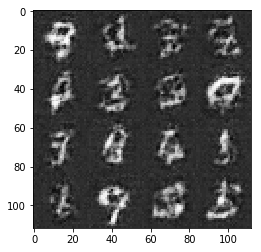

Epoch 0/2... Discriminator Loss: 0.0600... Generator Loss: 3.3203
Epoch 0/2... Discriminator Loss: 0.0867... Generator Loss: 2.9234
Epoch 0/2... Discriminator Loss: 0.0880... Generator Loss: 3.1747
Epoch 0/2... Discriminator Loss: 0.0547... Generator Loss: 3.3967
Epoch 0/2... Discriminator Loss: 0.1018... Generator Loss: 2.7854


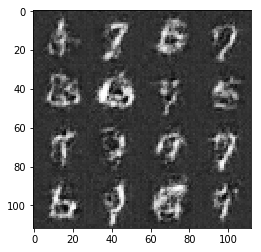

Epoch 0/2... Discriminator Loss: 0.0662... Generator Loss: 3.2493
Epoch 0/2... Discriminator Loss: 0.0733... Generator Loss: 3.0533
Epoch 0/2... Discriminator Loss: 0.3068... Generator Loss: 1.5488
Epoch 0/2... Discriminator Loss: 0.0715... Generator Loss: 3.2255
Epoch 0/2... Discriminator Loss: 0.1241... Generator Loss: 2.5170


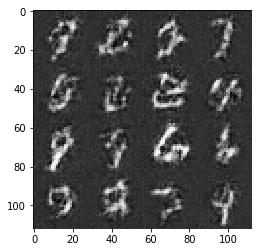

Epoch 0/2... Discriminator Loss: 0.0589... Generator Loss: 3.5662
Epoch 0/2... Discriminator Loss: 0.0567... Generator Loss: 3.4563
Epoch 0/2... Discriminator Loss: 0.0351... Generator Loss: 3.7878
Epoch 0/2... Discriminator Loss: 0.0577... Generator Loss: 3.3484
Epoch 0/2... Discriminator Loss: 0.0859... Generator Loss: 2.9153


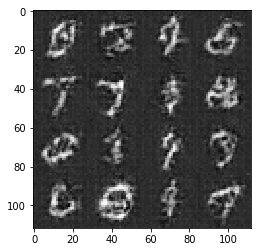

Epoch 0/2... Discriminator Loss: 0.0807... Generator Loss: 3.0596
Epoch 0/2... Discriminator Loss: 0.0790... Generator Loss: 2.9896
Epoch 0/2... Discriminator Loss: 0.0930... Generator Loss: 2.9451
Epoch 0/2... Discriminator Loss: 0.0525... Generator Loss: 3.5354
Epoch 0/2... Discriminator Loss: 0.0486... Generator Loss: 3.3936


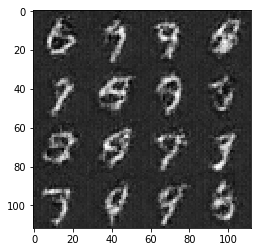

Epoch 0/2... Discriminator Loss: 0.0489... Generator Loss: 4.1707
Epoch 0/2... Discriminator Loss: 0.8729... Generator Loss: 1.2088
Epoch 0/2... Discriminator Loss: 1.3460... Generator Loss: 2.9909
Epoch 0/2... Discriminator Loss: 0.5027... Generator Loss: 2.1938
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 0.6225


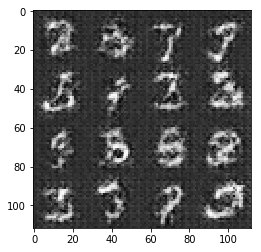

Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 2.6661
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.4022
Epoch 1/2... Discriminator Loss: 0.4562... Generator Loss: 2.1709
Epoch 1/2... Discriminator Loss: 0.4384... Generator Loss: 1.3889
Epoch 1/2... Discriminator Loss: 0.5571... Generator Loss: 1.0318


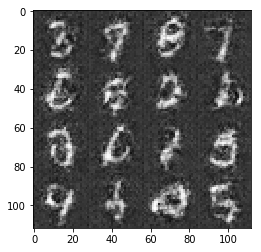

Epoch 1/2... Discriminator Loss: 0.3091... Generator Loss: 1.6990
Epoch 1/2... Discriminator Loss: 0.2660... Generator Loss: 1.8751
Epoch 1/2... Discriminator Loss: 0.4385... Generator Loss: 1.2828
Epoch 1/2... Discriminator Loss: 0.3359... Generator Loss: 1.4817
Epoch 1/2... Discriminator Loss: 0.4777... Generator Loss: 1.1605


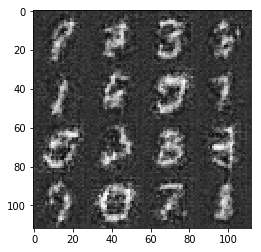

Epoch 1/2... Discriminator Loss: 0.5054... Generator Loss: 1.1345
Epoch 1/2... Discriminator Loss: 0.5016... Generator Loss: 1.1301
Epoch 1/2... Discriminator Loss: 0.2972... Generator Loss: 1.7167
Epoch 1/2... Discriminator Loss: 0.4844... Generator Loss: 1.2090
Epoch 1/2... Discriminator Loss: 0.2372... Generator Loss: 1.9509


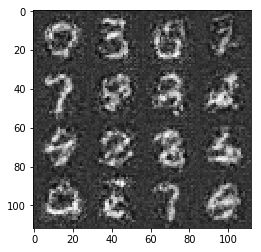

Epoch 1/2... Discriminator Loss: 0.3487... Generator Loss: 1.4928
Epoch 1/2... Discriminator Loss: 0.1698... Generator Loss: 2.1987
Epoch 1/2... Discriminator Loss: 0.3247... Generator Loss: 1.5393
Epoch 1/2... Discriminator Loss: 0.3159... Generator Loss: 1.5359
Epoch 1/2... Discriminator Loss: 0.3426... Generator Loss: 1.5283


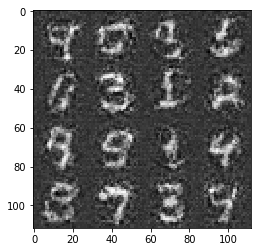

Epoch 1/2... Discriminator Loss: 0.2368... Generator Loss: 1.8912
Epoch 1/2... Discriminator Loss: 0.5082... Generator Loss: 1.1224
Epoch 1/2... Discriminator Loss: 0.0679... Generator Loss: 3.1491
Epoch 1/2... Discriminator Loss: 0.1101... Generator Loss: 2.5529
Epoch 1/2... Discriminator Loss: 0.4146... Generator Loss: 1.3210


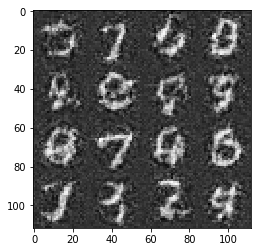

Epoch 1/2... Discriminator Loss: 0.1039... Generator Loss: 2.8081
Epoch 1/2... Discriminator Loss: 0.2329... Generator Loss: 1.7925
Epoch 1/2... Discriminator Loss: 0.0765... Generator Loss: 2.9847
Epoch 1/2... Discriminator Loss: 0.0396... Generator Loss: 3.8242
Epoch 1/2... Discriminator Loss: 0.3132... Generator Loss: 1.6294


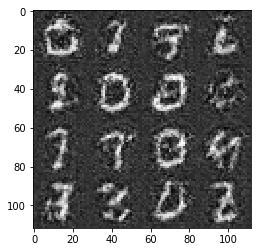

Epoch 1/2... Discriminator Loss: 0.0604... Generator Loss: 3.4005
Epoch 1/2... Discriminator Loss: 0.2026... Generator Loss: 2.0149
Epoch 1/2... Discriminator Loss: 0.1771... Generator Loss: 2.0534
Epoch 1/2... Discriminator Loss: 0.0334... Generator Loss: 3.9818
Epoch 1/2... Discriminator Loss: 0.0195... Generator Loss: 4.8383


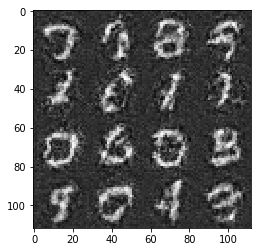

Epoch 1/2... Discriminator Loss: 0.0772... Generator Loss: 3.0538
Epoch 1/2... Discriminator Loss: 0.1014... Generator Loss: 2.7645
Epoch 1/2... Discriminator Loss: 0.0150... Generator Loss: 5.0079
Epoch 1/2... Discriminator Loss: 4.9629... Generator Loss: 3.8102
Epoch 1/2... Discriminator Loss: 1.9897... Generator Loss: 0.4516


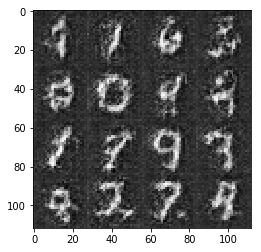

Epoch 1/2... Discriminator Loss: 2.3452... Generator Loss: 0.9103
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 1.0501
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 1.8715
Epoch 1/2... Discriminator Loss: 0.7236... Generator Loss: 1.0822


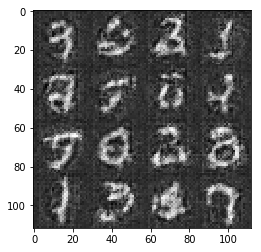

Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 0.8936
Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 1.2491
Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 2.8227
Epoch 1/2... Discriminator Loss: 0.6127... Generator Loss: 2.5032
Epoch 1/2... Discriminator Loss: 0.3645... Generator Loss: 1.6387


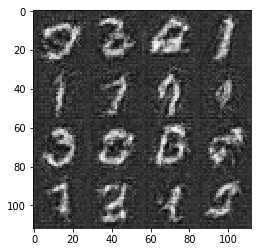

Epoch 1/2... Discriminator Loss: 0.4020... Generator Loss: 1.3748
Epoch 1/2... Discriminator Loss: 0.7662... Generator Loss: 3.2077
Epoch 1/2... Discriminator Loss: 0.3005... Generator Loss: 2.5516
Epoch 1/2... Discriminator Loss: 0.2513... Generator Loss: 2.1590
Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 1.3906


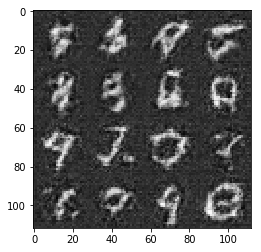

Epoch 1/2... Discriminator Loss: 0.2070... Generator Loss: 2.1373
Epoch 1/2... Discriminator Loss: 0.1929... Generator Loss: 2.3852
Epoch 1/2... Discriminator Loss: 0.3063... Generator Loss: 1.6256
Epoch 1/2... Discriminator Loss: 0.1503... Generator Loss: 2.4216
Epoch 1/2... Discriminator Loss: 0.1358... Generator Loss: 2.6470


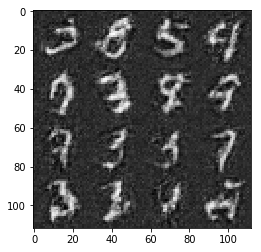

Epoch 1/2... Discriminator Loss: 0.1627... Generator Loss: 2.3846
Epoch 1/2... Discriminator Loss: 0.1960... Generator Loss: 2.1370
Epoch 1/2... Discriminator Loss: 0.1819... Generator Loss: 2.1702
Epoch 1/2... Discriminator Loss: 0.1627... Generator Loss: 2.2180
Epoch 1/2... Discriminator Loss: 0.2750... Generator Loss: 1.7258


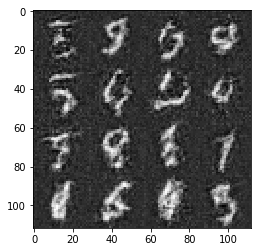

Epoch 1/2... Discriminator Loss: 0.1459... Generator Loss: 2.2583
Epoch 1/2... Discriminator Loss: 0.1056... Generator Loss: 2.7011
Epoch 1/2... Discriminator Loss: 0.1913... Generator Loss: 2.0655
Epoch 1/2... Discriminator Loss: 0.2809... Generator Loss: 1.7601
Epoch 1/2... Discriminator Loss: 0.0642... Generator Loss: 3.3156


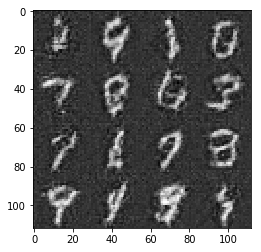

Epoch 1/2... Discriminator Loss: 0.0775... Generator Loss: 3.0771
Epoch 1/2... Discriminator Loss: 0.0273... Generator Loss: 4.2529
Epoch 1/2... Discriminator Loss: 0.1015... Generator Loss: 2.6975
Epoch 1/2... Discriminator Loss: 0.1500... Generator Loss: 2.4820
Epoch 1/2... Discriminator Loss: 0.0434... Generator Loss: 3.6230


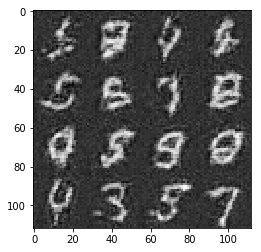

Epoch 1/2... Discriminator Loss: 0.0554... Generator Loss: 3.5381
Epoch 1/2... Discriminator Loss: 0.0763... Generator Loss: 3.3463
Epoch 1/2... Discriminator Loss: 0.0365... Generator Loss: 3.7494
Epoch 1/2... Discriminator Loss: 0.1108... Generator Loss: 2.6815
Epoch 1/2... Discriminator Loss: 0.0631... Generator Loss: 3.2836


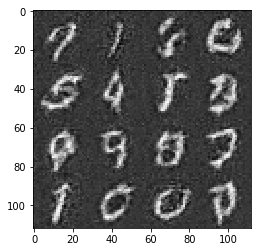

Epoch 1/2... Discriminator Loss: 0.1251... Generator Loss: 2.5133
Epoch 1/2... Discriminator Loss: 0.0386... Generator Loss: 4.0667
Epoch 1/2... Discriminator Loss: 0.0472... Generator Loss: 3.6425
Epoch 1/2... Discriminator Loss: 0.0239... Generator Loss: 4.2655
Epoch 1/2... Discriminator Loss: 0.0640... Generator Loss: 3.0313


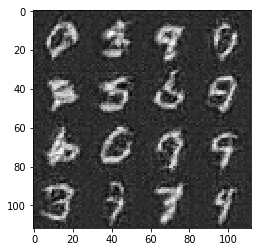

Epoch 1/2... Discriminator Loss: 0.0374... Generator Loss: 3.7214
Epoch 1/2... Discriminator Loss: 0.0583... Generator Loss: 3.3913
Epoch 1/2... Discriminator Loss: 0.0487... Generator Loss: 3.9362
Epoch 1/2... Discriminator Loss: 0.1181... Generator Loss: 2.5662
Epoch 1/2... Discriminator Loss: 1.9187... Generator Loss: 2.2884


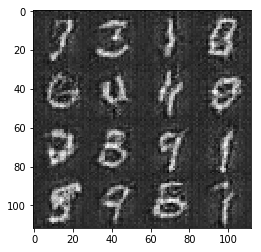

Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.8050


In [65]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.3542... Generator Loss: 1.8020
Epoch 0/1... Discriminator Loss: 0.9332... Generator Loss: 7.2222
Epoch 0/1... Discriminator Loss: 2.5865... Generator Loss: 0.2177
Epoch 0/1... Discriminator Loss: 1.3509... Generator Loss: 0.4642


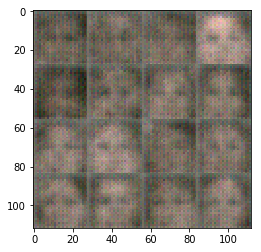

Epoch 0/1... Discriminator Loss: 0.3289... Generator Loss: 2.1014
Epoch 0/1... Discriminator Loss: 0.3928... Generator Loss: 1.5513
Epoch 0/1... Discriminator Loss: 0.1651... Generator Loss: 2.7790
Epoch 0/1... Discriminator Loss: 0.1282... Generator Loss: 4.1685
Epoch 0/1... Discriminator Loss: 0.0648... Generator Loss: 3.5206


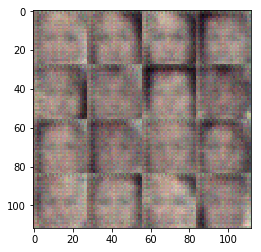

Epoch 0/1... Discriminator Loss: 0.1019... Generator Loss: 2.7488
Epoch 0/1... Discriminator Loss: 1.5084... Generator Loss: 0.6721
Epoch 0/1... Discriminator Loss: 0.6070... Generator Loss: 1.0156
Epoch 0/1... Discriminator Loss: 0.1392... Generator Loss: 3.6617
Epoch 0/1... Discriminator Loss: 0.6018... Generator Loss: 1.1098


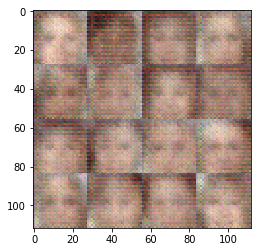

Epoch 0/1... Discriminator Loss: 3.6996... Generator Loss: 0.0451
Epoch 0/1... Discriminator Loss: 1.5034... Generator Loss: 0.4307
Epoch 0/1... Discriminator Loss: 1.9080... Generator Loss: 0.2640
Epoch 0/1... Discriminator Loss: 0.0537... Generator Loss: 3.3443
Epoch 0/1... Discriminator Loss: 0.5966... Generator Loss: 3.0262


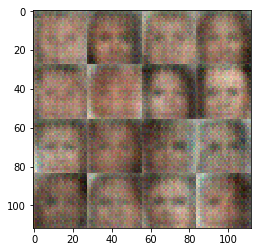

Epoch 0/1... Discriminator Loss: 0.9096... Generator Loss: 0.6575
Epoch 0/1... Discriminator Loss: 0.1225... Generator Loss: 2.6561
Epoch 0/1... Discriminator Loss: 4.9175... Generator Loss: 5.9030
Epoch 0/1... Discriminator Loss: 1.3708... Generator Loss: 0.6626
Epoch 0/1... Discriminator Loss: 1.3075... Generator Loss: 0.6820


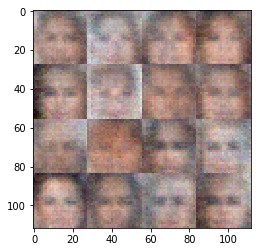

Epoch 0/1... Discriminator Loss: 1.3473... Generator Loss: 0.6664
Epoch 0/1... Discriminator Loss: 1.0800... Generator Loss: 0.7417
Epoch 0/1... Discriminator Loss: 0.9162... Generator Loss: 1.5033
Epoch 0/1... Discriminator Loss: 1.2066... Generator Loss: 0.6405
Epoch 0/1... Discriminator Loss: 1.1808... Generator Loss: 0.5702


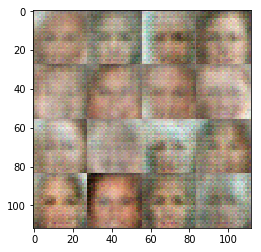

Epoch 0/1... Discriminator Loss: 1.4598... Generator Loss: 4.5027
Epoch 0/1... Discriminator Loss: 2.5965... Generator Loss: 4.5538
Epoch 0/1... Discriminator Loss: 0.7117... Generator Loss: 1.4262
Epoch 0/1... Discriminator Loss: 0.5314... Generator Loss: 1.1067
Epoch 0/1... Discriminator Loss: 0.2825... Generator Loss: 1.7047


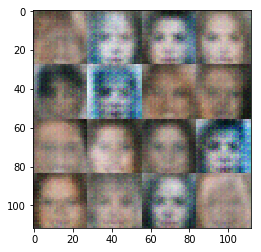

Epoch 0/1... Discriminator Loss: 0.0796... Generator Loss: 3.2886
Epoch 0/1... Discriminator Loss: 0.0615... Generator Loss: 3.9828
Epoch 0/1... Discriminator Loss: 0.9241... Generator Loss: 0.7019
Epoch 0/1... Discriminator Loss: 0.0274... Generator Loss: 4.6160
Epoch 0/1... Discriminator Loss: 0.0554... Generator Loss: 4.0764


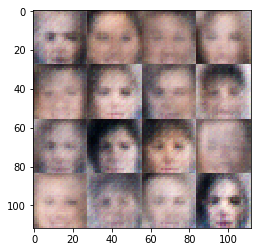

Epoch 0/1... Discriminator Loss: 0.2138... Generator Loss: 1.9196
Epoch 0/1... Discriminator Loss: 1.1123... Generator Loss: 4.6872
Epoch 0/1... Discriminator Loss: 0.0703... Generator Loss: 11.0245
Epoch 0/1... Discriminator Loss: 0.3093... Generator Loss: 11.0731
Epoch 0/1... Discriminator Loss: 0.7073... Generator Loss: 1.5768


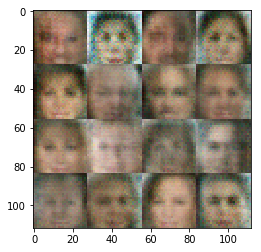

Epoch 0/1... Discriminator Loss: 0.6535... Generator Loss: 0.9481
Epoch 0/1... Discriminator Loss: 0.4794... Generator Loss: 1.1588
Epoch 0/1... Discriminator Loss: 0.0127... Generator Loss: 4.9580
Epoch 0/1... Discriminator Loss: 0.0185... Generator Loss: 5.7680
Epoch 0/1... Discriminator Loss: 0.3451... Generator Loss: 1.4718


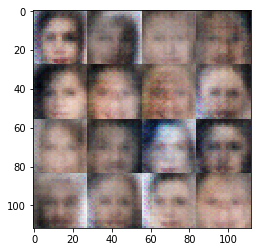

Epoch 0/1... Discriminator Loss: 0.0938... Generator Loss: 2.9191
Epoch 0/1... Discriminator Loss: 0.0013... Generator Loss: 8.4166
Epoch 0/1... Discriminator Loss: 0.0420... Generator Loss: 3.7818
Epoch 0/1... Discriminator Loss: 0.0063... Generator Loss: 6.3657
Epoch 0/1... Discriminator Loss: 0.0024... Generator Loss: 9.3775


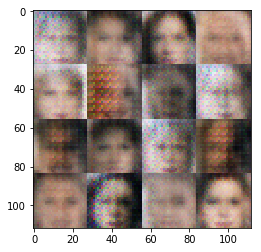

Epoch 0/1... Discriminator Loss: 0.0040... Generator Loss: 8.2974
Epoch 0/1... Discriminator Loss: 0.1319... Generator Loss: 2.6214
Epoch 0/1... Discriminator Loss: 0.0054... Generator Loss: 6.1864
Epoch 0/1... Discriminator Loss: 0.0150... Generator Loss: 7.0328
Epoch 0/1... Discriminator Loss: 0.0031... Generator Loss: 10.2392


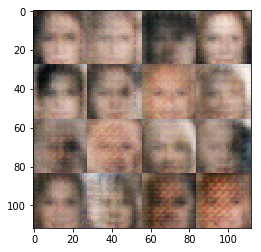

Epoch 0/1... Discriminator Loss: 0.0531... Generator Loss: 3.3526
Epoch 0/1... Discriminator Loss: 0.0104... Generator Loss: 5.4294
Epoch 0/1... Discriminator Loss: 0.0038... Generator Loss: 8.5527
Epoch 0/1... Discriminator Loss: 0.0020... Generator Loss: 7.6610
Epoch 0/1... Discriminator Loss: 0.0030... Generator Loss: 7.0395


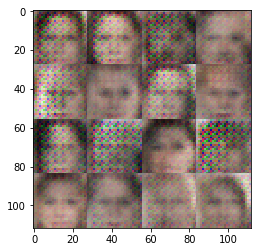

Epoch 0/1... Discriminator Loss: 0.0005... Generator Loss: 10.1225
Epoch 0/1... Discriminator Loss: 0.0307... Generator Loss: 4.2464
Epoch 0/1... Discriminator Loss: 0.0063... Generator Loss: 5.8963
Epoch 0/1... Discriminator Loss: 0.0034... Generator Loss: 6.8476
Epoch 0/1... Discriminator Loss: 0.0001... Generator Loss: 11.5554


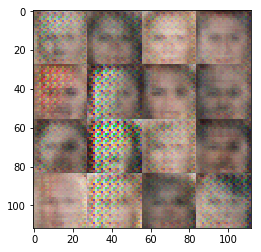

Epoch 0/1... Discriminator Loss: 0.0002... Generator Loss: 10.0261
Epoch 0/1... Discriminator Loss: 0.0404... Generator Loss: 3.8960
Epoch 0/1... Discriminator Loss: 0.0006... Generator Loss: 9.1266
Epoch 0/1... Discriminator Loss: 0.0077... Generator Loss: 6.5769
Epoch 0/1... Discriminator Loss: 0.0005... Generator Loss: 10.8229


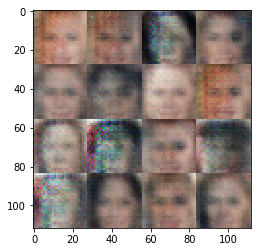

Epoch 0/1... Discriminator Loss: 0.0682... Generator Loss: 3.5099
Epoch 0/1... Discriminator Loss: 0.0008... Generator Loss: 8.4654
Epoch 0/1... Discriminator Loss: 0.0046... Generator Loss: 10.8486
Epoch 0/1... Discriminator Loss: 0.0053... Generator Loss: 6.0991
Epoch 0/1... Discriminator Loss: 0.0033... Generator Loss: 10.8424


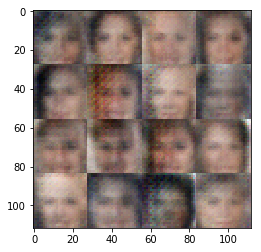

Epoch 0/1... Discriminator Loss: 0.0065... Generator Loss: 5.7451
Epoch 0/1... Discriminator Loss: 0.0172... Generator Loss: 10.3834
Epoch 0/1... Discriminator Loss: 0.0510... Generator Loss: 3.9763
Epoch 0/1... Discriminator Loss: 0.0007... Generator Loss: 11.3547
Epoch 0/1... Discriminator Loss: 0.0148... Generator Loss: 4.8375


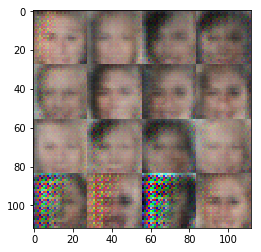

Epoch 0/1... Discriminator Loss: 0.0012... Generator Loss: 10.2133
Epoch 0/1... Discriminator Loss: 0.0015... Generator Loss: 7.4987
Epoch 0/1... Discriminator Loss: 0.0006... Generator Loss: 10.8922
Epoch 0/1... Discriminator Loss: 0.0480... Generator Loss: 3.6605
Epoch 0/1... Discriminator Loss: 0.0004... Generator Loss: 10.8890


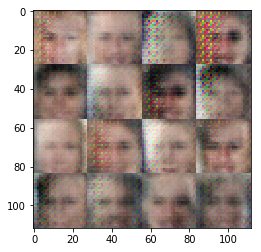

Epoch 0/1... Discriminator Loss: 0.0006... Generator Loss: 9.9360
Epoch 0/1... Discriminator Loss: 0.0112... Generator Loss: 5.1777
Epoch 0/1... Discriminator Loss: 0.0063... Generator Loss: 7.2756
Epoch 0/1... Discriminator Loss: 0.0011... Generator Loss: 9.4129
Epoch 0/1... Discriminator Loss: 0.0053... Generator Loss: 8.4624


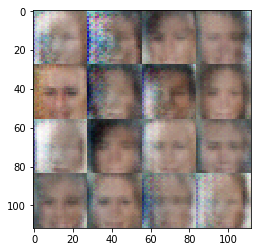

Epoch 0/1... Discriminator Loss: 0.7591... Generator Loss: 1.3025
Epoch 0/1... Discriminator Loss: 1.0953... Generator Loss: 1.0903
Epoch 0/1... Discriminator Loss: 0.0604... Generator Loss: 6.6334
Epoch 0/1... Discriminator Loss: 0.2083... Generator Loss: 4.9530
Epoch 0/1... Discriminator Loss: 0.9045... Generator Loss: 1.5375


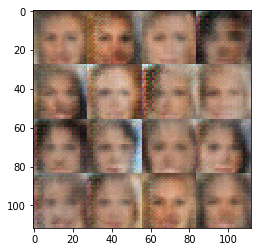

Epoch 0/1... Discriminator Loss: 0.0902... Generator Loss: 3.3273
Epoch 0/1... Discriminator Loss: 0.0474... Generator Loss: 8.9758
Epoch 0/1... Discriminator Loss: 0.0213... Generator Loss: 4.6225
Epoch 0/1... Discriminator Loss: 0.0265... Generator Loss: 7.2191
Epoch 0/1... Discriminator Loss: 0.0069... Generator Loss: 7.7206


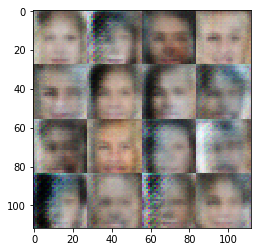

Epoch 0/1... Discriminator Loss: 0.0180... Generator Loss: 9.3823
Epoch 0/1... Discriminator Loss: 0.0140... Generator Loss: 7.5927
Epoch 0/1... Discriminator Loss: 0.0106... Generator Loss: 6.3572
Epoch 0/1... Discriminator Loss: 0.3196... Generator Loss: 2.9737
Epoch 0/1... Discriminator Loss: 1.7383... Generator Loss: 0.2720


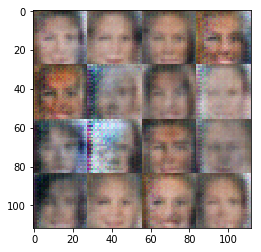

Epoch 0/1... Discriminator Loss: 0.0242... Generator Loss: 4.8719
Epoch 0/1... Discriminator Loss: 0.0018... Generator Loss: 7.7325
Epoch 0/1... Discriminator Loss: 0.0425... Generator Loss: 4.4384
Epoch 0/1... Discriminator Loss: 0.0256... Generator Loss: 4.8146
Epoch 0/1... Discriminator Loss: 0.0048... Generator Loss: 9.0201


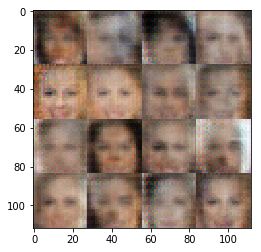

Epoch 0/1... Discriminator Loss: 0.0090... Generator Loss: 9.6151
Epoch 0/1... Discriminator Loss: 0.0064... Generator Loss: 8.4103
Epoch 0/1... Discriminator Loss: 0.0164... Generator Loss: 9.3794
Epoch 0/1... Discriminator Loss: 0.0113... Generator Loss: 10.1486
Epoch 0/1... Discriminator Loss: 0.0097... Generator Loss: 7.0891


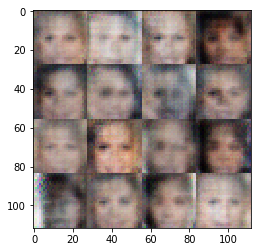

Epoch 0/1... Discriminator Loss: 0.0064... Generator Loss: 8.0084
Epoch 0/1... Discriminator Loss: 0.0406... Generator Loss: 6.0339
Epoch 0/1... Discriminator Loss: 0.0680... Generator Loss: 3.1740
Epoch 0/1... Discriminator Loss: 0.0469... Generator Loss: 4.1963
Epoch 0/1... Discriminator Loss: 0.0033... Generator Loss: 7.4507


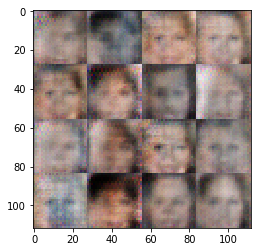

Epoch 0/1... Discriminator Loss: 0.0119... Generator Loss: 9.6271
Epoch 0/1... Discriminator Loss: 0.0026... Generator Loss: 9.6010
Epoch 0/1... Discriminator Loss: 0.0395... Generator Loss: 4.2365
Epoch 0/1... Discriminator Loss: 0.0090... Generator Loss: 9.6461
Epoch 0/1... Discriminator Loss: 3.8377... Generator Loss: 2.5942


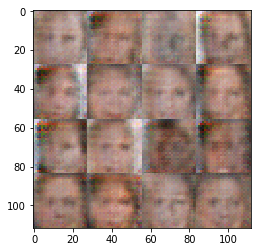

Epoch 0/1... Discriminator Loss: 0.9834... Generator Loss: 0.9281
Epoch 0/1... Discriminator Loss: 1.0299... Generator Loss: 1.1494
Epoch 0/1... Discriminator Loss: 2.1067... Generator Loss: 0.2911
Epoch 0/1... Discriminator Loss: 0.6888... Generator Loss: 1.3297
Epoch 0/1... Discriminator Loss: 1.5462... Generator Loss: 0.4077


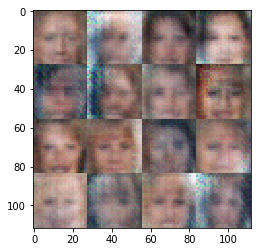

Epoch 0/1... Discriminator Loss: 1.0822... Generator Loss: 1.7054
Epoch 0/1... Discriminator Loss: 1.0946... Generator Loss: 0.6554
Epoch 0/1... Discriminator Loss: 1.2573... Generator Loss: 1.2673
Epoch 0/1... Discriminator Loss: 1.5773... Generator Loss: 0.3396
Epoch 0/1... Discriminator Loss: 1.3779... Generator Loss: 0.4569


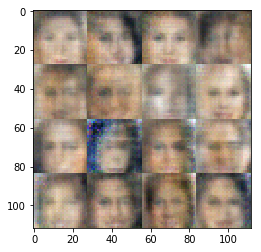

Epoch 0/1... Discriminator Loss: 0.9853... Generator Loss: 1.7072
Epoch 0/1... Discriminator Loss: 1.4332... Generator Loss: 0.3860
Epoch 0/1... Discriminator Loss: 1.5944... Generator Loss: 0.3287
Epoch 0/1... Discriminator Loss: 0.7004... Generator Loss: 1.2379
Epoch 0/1... Discriminator Loss: 0.9640... Generator Loss: 1.0561


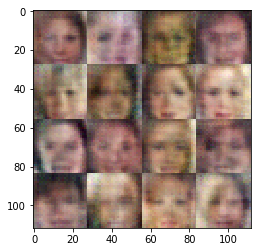

Epoch 0/1... Discriminator Loss: 0.7126... Generator Loss: 1.3021
Epoch 0/1... Discriminator Loss: 0.8097... Generator Loss: 0.8916
Epoch 0/1... Discriminator Loss: 0.4866... Generator Loss: 7.3667
Epoch 0/1... Discriminator Loss: 1.2582... Generator Loss: 1.2181
Epoch 0/1... Discriminator Loss: 0.9193... Generator Loss: 0.8830


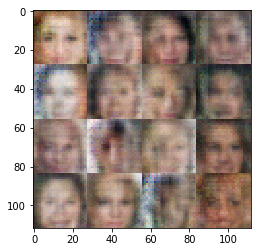

Epoch 0/1... Discriminator Loss: 1.0584... Generator Loss: 1.9140
Epoch 0/1... Discriminator Loss: 1.0233... Generator Loss: 0.6694
Epoch 0/1... Discriminator Loss: 0.0344... Generator Loss: 6.5339
Epoch 0/1... Discriminator Loss: 0.0954... Generator Loss: 3.0222
Epoch 0/1... Discriminator Loss: 0.0158... Generator Loss: 5.7729


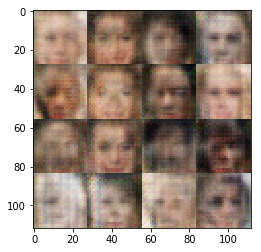

Epoch 0/1... Discriminator Loss: 1.4451... Generator Loss: 8.8030
Epoch 0/1... Discriminator Loss: 1.1199... Generator Loss: 0.8051
Epoch 0/1... Discriminator Loss: 0.8208... Generator Loss: 4.9717
Epoch 0/1... Discriminator Loss: 0.0505... Generator Loss: 5.9440
Epoch 0/1... Discriminator Loss: 0.4534... Generator Loss: 1.3698


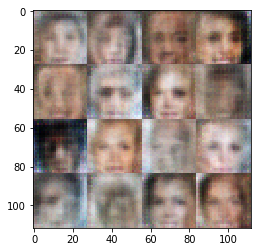

Epoch 0/1... Discriminator Loss: 1.5723... Generator Loss: 0.3569
Epoch 0/1... Discriminator Loss: 0.2741... Generator Loss: 8.0872
Epoch 0/1... Discriminator Loss: 0.0041... Generator Loss: 7.1210
Epoch 0/1... Discriminator Loss: 0.0155... Generator Loss: 9.4047
Epoch 0/1... Discriminator Loss: 0.6853... Generator Loss: 7.4388


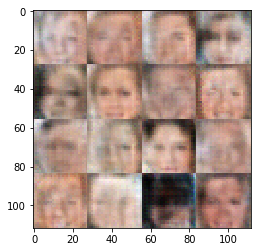

Epoch 0/1... Discriminator Loss: 0.3992... Generator Loss: 1.4013
Epoch 0/1... Discriminator Loss: 0.0029... Generator Loss: 8.4817
Epoch 0/1... Discriminator Loss: 0.0365... Generator Loss: 5.3920
Epoch 0/1... Discriminator Loss: 0.0092... Generator Loss: 5.4503
Epoch 0/1... Discriminator Loss: 0.0220... Generator Loss: 4.5407


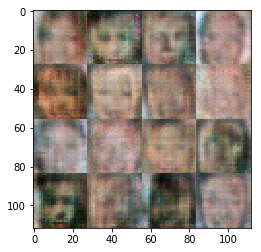

Epoch 0/1... Discriminator Loss: 0.0063... Generator Loss: 8.8982
Epoch 0/1... Discriminator Loss: 0.1270... Generator Loss: 2.4453
Epoch 0/1... Discriminator Loss: 0.0029... Generator Loss: 7.1078
Epoch 0/1... Discriminator Loss: 0.1325... Generator Loss: 2.6558
Epoch 0/1... Discriminator Loss: 0.0103... Generator Loss: 5.2394


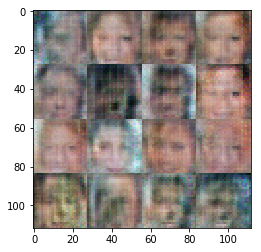

Epoch 0/1... Discriminator Loss: 0.0301... Generator Loss: 7.6486
Epoch 0/1... Discriminator Loss: 0.0027... Generator Loss: 8.9957
Epoch 0/1... Discriminator Loss: 0.0018... Generator Loss: 7.2627
Epoch 0/1... Discriminator Loss: 0.0012... Generator Loss: 10.0135
Epoch 0/1... Discriminator Loss: 0.0036... Generator Loss: 6.5935


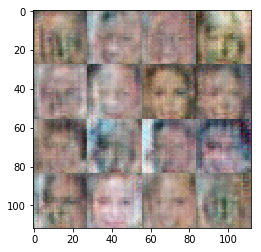

Epoch 0/1... Discriminator Loss: 0.0198... Generator Loss: 4.5961
Epoch 0/1... Discriminator Loss: 0.0015... Generator Loss: 7.8922
Epoch 0/1... Discriminator Loss: 0.0047... Generator Loss: 6.2337
Epoch 0/1... Discriminator Loss: 0.0062... Generator Loss: 5.7806
Epoch 0/1... Discriminator Loss: 0.0193... Generator Loss: 4.3987


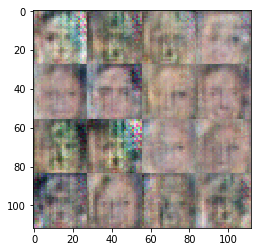

Epoch 0/1... Discriminator Loss: 0.0024... Generator Loss: 7.0859
Epoch 0/1... Discriminator Loss: 0.0013... Generator Loss: 8.9819
Epoch 0/1... Discriminator Loss: 0.0048... Generator Loss: 6.2252
Epoch 0/1... Discriminator Loss: 0.0669... Generator Loss: 3.7714
Epoch 0/1... Discriminator Loss: 0.0028... Generator Loss: 9.4613


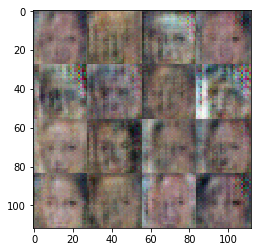

Epoch 0/1... Discriminator Loss: 0.0041... Generator Loss: 6.5674
Epoch 0/1... Discriminator Loss: 0.0120... Generator Loss: 5.4031
Epoch 0/1... Discriminator Loss: 0.0049... Generator Loss: 10.1546
Epoch 0/1... Discriminator Loss: 0.0010... Generator Loss: 9.0390
Epoch 0/1... Discriminator Loss: 0.0022... Generator Loss: 7.3623


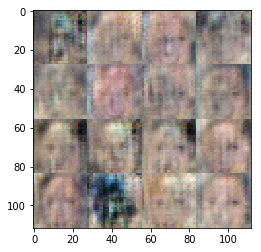

Epoch 0/1... Discriminator Loss: 0.0043... Generator Loss: 6.6546
Epoch 0/1... Discriminator Loss: 0.0168... Generator Loss: 4.8744
Epoch 0/1... Discriminator Loss: 0.0044... Generator Loss: 6.2312
Epoch 0/1... Discriminator Loss: 0.0009... Generator Loss: 8.1982
Epoch 0/1... Discriminator Loss: 0.0066... Generator Loss: 5.6050


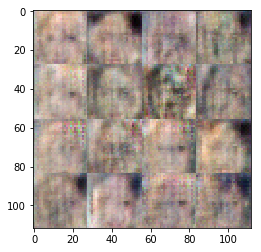

Epoch 0/1... Discriminator Loss: 0.0033... Generator Loss: 6.4139
Epoch 0/1... Discriminator Loss: 0.0011... Generator Loss: 8.5166
Epoch 0/1... Discriminator Loss: 0.0024... Generator Loss: 7.1828
Epoch 0/1... Discriminator Loss: 0.0010... Generator Loss: 8.9019
Epoch 0/1... Discriminator Loss: 0.0023... Generator Loss: 7.2910


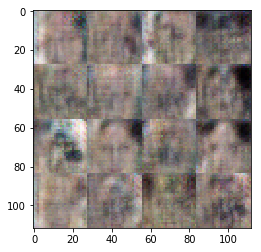

Epoch 0/1... Discriminator Loss: 0.0059... Generator Loss: 6.3659
Epoch 0/1... Discriminator Loss: 0.0119... Generator Loss: 5.4464
Epoch 0/1... Discriminator Loss: 0.0011... Generator Loss: 8.6585
Epoch 0/1... Discriminator Loss: 0.0038... Generator Loss: 6.5566
Epoch 0/1... Discriminator Loss: 0.0025... Generator Loss: 7.4912


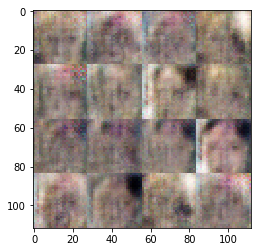

Epoch 0/1... Discriminator Loss: 0.0032... Generator Loss: 7.5296
Epoch 0/1... Discriminator Loss: 0.0055... Generator Loss: 6.1301
Epoch 0/1... Discriminator Loss: 0.0033... Generator Loss: 6.9502
Epoch 0/1... Discriminator Loss: 0.0031... Generator Loss: 7.1808
Epoch 0/1... Discriminator Loss: 0.0006... Generator Loss: 8.6851


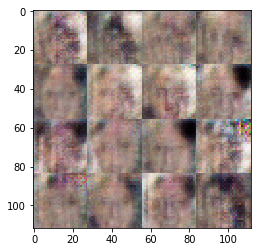

Epoch 0/1... Discriminator Loss: 0.0168... Generator Loss: 5.0092
Epoch 0/1... Discriminator Loss: 0.0071... Generator Loss: 7.9540
Epoch 0/1... Discriminator Loss: 0.0071... Generator Loss: 5.5467
Epoch 0/1... Discriminator Loss: 0.0113... Generator Loss: 5.4305
Epoch 0/1... Discriminator Loss: 0.0070... Generator Loss: 5.7764


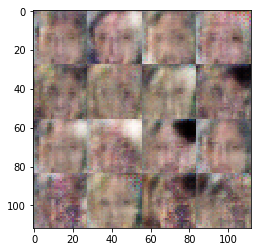

Epoch 0/1... Discriminator Loss: 0.0101... Generator Loss: 5.4343
Epoch 0/1... Discriminator Loss: 0.0027... Generator Loss: 7.3884
Epoch 0/1... Discriminator Loss: 0.0018... Generator Loss: 7.5437
Epoch 0/1... Discriminator Loss: 0.0015... Generator Loss: 7.9071
Epoch 0/1... Discriminator Loss: 0.0112... Generator Loss: 12.5366


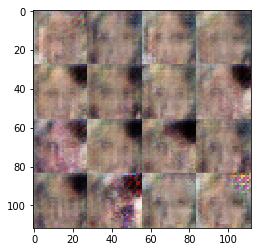

Epoch 0/1... Discriminator Loss: 0.0008... Generator Loss: 9.3521
Epoch 0/1... Discriminator Loss: 0.0151... Generator Loss: 5.1258
Epoch 0/1... Discriminator Loss: 0.0005... Generator Loss: 8.9289
Epoch 0/1... Discriminator Loss: 0.0050... Generator Loss: 6.2371
Epoch 0/1... Discriminator Loss: 0.0048... Generator Loss: 6.9025


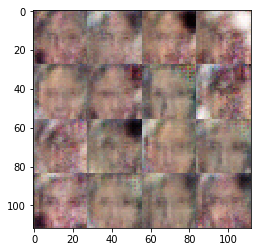

Epoch 0/1... Discriminator Loss: 0.1529... Generator Loss: 2.4209
Epoch 0/1... Discriminator Loss: 0.0206... Generator Loss: 4.7811
Epoch 0/1... Discriminator Loss: 0.0341... Generator Loss: 8.5929
Epoch 0/1... Discriminator Loss: 0.0045... Generator Loss: 6.7615
Epoch 0/1... Discriminator Loss: 0.7905... Generator Loss: 1.7737


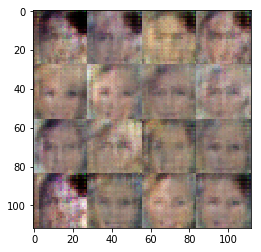

Epoch 0/1... Discriminator Loss: 0.0468... Generator Loss: 4.2216
Epoch 0/1... Discriminator Loss: 0.0696... Generator Loss: 4.6251
Epoch 0/1... Discriminator Loss: 0.1468... Generator Loss: 3.3868
Epoch 0/1... Discriminator Loss: 0.0122... Generator Loss: 5.9780
Epoch 0/1... Discriminator Loss: 0.1618... Generator Loss: 4.1478


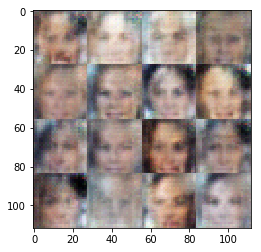

Epoch 0/1... Discriminator Loss: 1.0772... Generator Loss: 4.6607
Epoch 0/1... Discriminator Loss: 0.0076... Generator Loss: 7.5011
Epoch 0/1... Discriminator Loss: 0.4336... Generator Loss: 1.3326
Epoch 0/1... Discriminator Loss: 0.0823... Generator Loss: 3.3197
Epoch 0/1... Discriminator Loss: 0.2278... Generator Loss: 2.6650


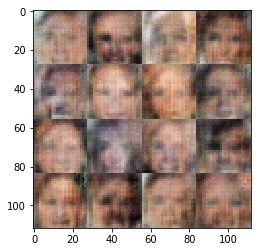

Epoch 0/1... Discriminator Loss: 0.4287... Generator Loss: 1.3891
Epoch 0/1... Discriminator Loss: 0.0475... Generator Loss: 3.8516
Epoch 0/1... Discriminator Loss: 0.0463... Generator Loss: 5.4885
Epoch 0/1... Discriminator Loss: 0.1480... Generator Loss: 3.3208
Epoch 0/1... Discriminator Loss: 0.4591... Generator Loss: 1.4263


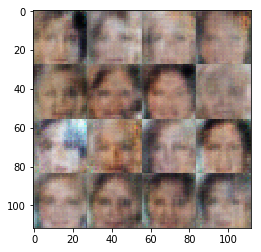

Epoch 0/1... Discriminator Loss: 0.3080... Generator Loss: 1.9000
Epoch 0/1... Discriminator Loss: 0.0791... Generator Loss: 4.9960
Epoch 0/1... Discriminator Loss: 0.0318... Generator Loss: 5.1306
Epoch 0/1... Discriminator Loss: 6.0347... Generator Loss: 7.9237
Epoch 0/1... Discriminator Loss: 0.0925... Generator Loss: 6.0293


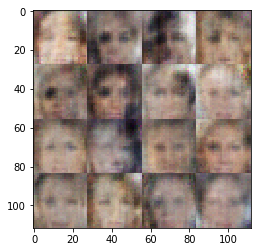

Epoch 0/1... Discriminator Loss: 0.0375... Generator Loss: 6.7543
Epoch 0/1... Discriminator Loss: 0.3942... Generator Loss: 1.6464
Epoch 0/1... Discriminator Loss: 0.1461... Generator Loss: 2.7164
Epoch 0/1... Discriminator Loss: 0.1865... Generator Loss: 2.5333
Epoch 0/1... Discriminator Loss: 0.1187... Generator Loss: 5.9427


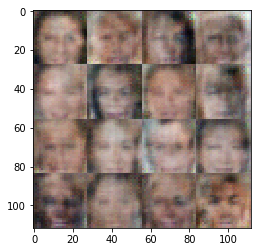

Epoch 0/1... Discriminator Loss: 0.0320... Generator Loss: 9.1238
Epoch 0/1... Discriminator Loss: 0.5226... Generator Loss: 8.9768
Epoch 0/1... Discriminator Loss: 0.0348... Generator Loss: 6.2858
Epoch 0/1... Discriminator Loss: 0.0557... Generator Loss: 9.3974
Epoch 0/1... Discriminator Loss: 2.7736... Generator Loss: 5.6915


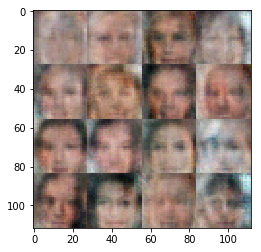

Epoch 0/1... Discriminator Loss: 0.7092... Generator Loss: 1.0884
Epoch 0/1... Discriminator Loss: 0.0484... Generator Loss: 6.4964
Epoch 0/1... Discriminator Loss: 0.0599... Generator Loss: 9.5902
Epoch 0/1... Discriminator Loss: 0.0132... Generator Loss: 7.1403
Epoch 0/1... Discriminator Loss: 0.0049... Generator Loss: 9.8864


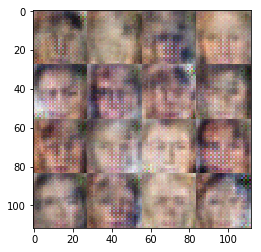

Epoch 0/1... Discriminator Loss: 0.0093... Generator Loss: 5.1251
Epoch 0/1... Discriminator Loss: 0.0232... Generator Loss: 9.0717
Epoch 0/1... Discriminator Loss: 0.0045... Generator Loss: 5.9329
Epoch 0/1... Discriminator Loss: 0.0033... Generator Loss: 6.2759
Epoch 0/1... Discriminator Loss: 0.0149... Generator Loss: 4.5497


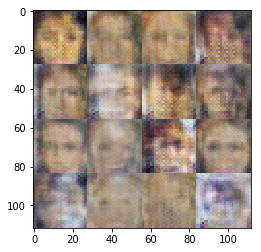

Epoch 0/1... Discriminator Loss: 0.0027... Generator Loss: 7.7562
Epoch 0/1... Discriminator Loss: 0.0027... Generator Loss: 6.5110
Epoch 0/1... Discriminator Loss: 0.0038... Generator Loss: 6.7913
Epoch 0/1... Discriminator Loss: 0.0040... Generator Loss: 5.9810
Epoch 0/1... Discriminator Loss: 0.0012... Generator Loss: 7.8065


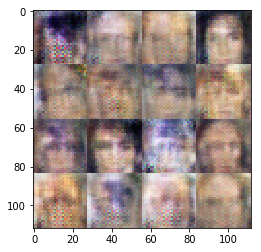

Epoch 0/1... Discriminator Loss: 0.0054... Generator Loss: 6.4472
Epoch 0/1... Discriminator Loss: 0.0090... Generator Loss: 5.0555
Epoch 0/1... Discriminator Loss: 0.0016... Generator Loss: 7.4226
Epoch 0/1... Discriminator Loss: 0.0077... Generator Loss: 5.5787
Epoch 0/1... Discriminator Loss: 0.0697... Generator Loss: 9.7241


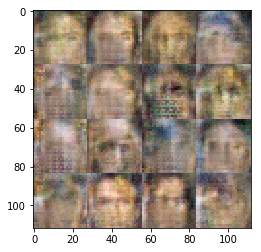

Epoch 0/1... Discriminator Loss: 0.0065... Generator Loss: 6.2061
Epoch 0/1... Discriminator Loss: 0.0008... Generator Loss: 8.4523
Epoch 0/1... Discriminator Loss: 0.1062... Generator Loss: 2.5052
Epoch 0/1... Discriminator Loss: 0.0012... Generator Loss: 7.8186
Epoch 0/1... Discriminator Loss: 0.0028... Generator Loss: 6.7936


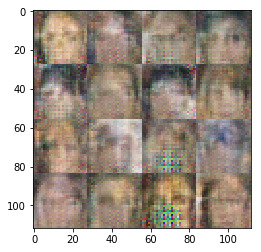

Epoch 0/1... Discriminator Loss: 0.0022... Generator Loss: 6.9090
Epoch 0/1... Discriminator Loss: 0.0048... Generator Loss: 5.9377
Epoch 0/1... Discriminator Loss: 0.0043... Generator Loss: 6.0128
Epoch 0/1... Discriminator Loss: 0.0034... Generator Loss: 6.2162
Epoch 0/1... Discriminator Loss: 0.0052... Generator Loss: 5.6851


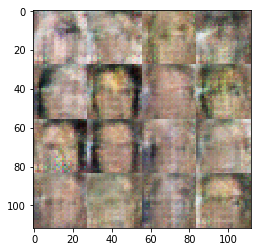

Epoch 0/1... Discriminator Loss: 0.0044... Generator Loss: 5.7425
Epoch 0/1... Discriminator Loss: 0.0133... Generator Loss: 4.6514
Epoch 0/1... Discriminator Loss: 0.0099... Generator Loss: 4.9222
Epoch 0/1... Discriminator Loss: 0.0118... Generator Loss: 4.8185
Epoch 0/1... Discriminator Loss: 0.0059... Generator Loss: 5.3765


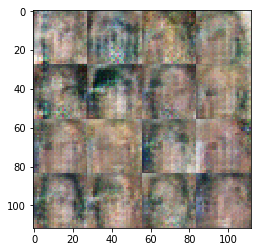

Epoch 0/1... Discriminator Loss: 0.0045... Generator Loss: 5.6282
Epoch 0/1... Discriminator Loss: 0.0079... Generator Loss: 5.1376
Epoch 0/1... Discriminator Loss: 0.0095... Generator Loss: 4.8993
Epoch 0/1... Discriminator Loss: 0.0125... Generator Loss: 4.6016
Epoch 0/1... Discriminator Loss: 0.0108... Generator Loss: 4.7422


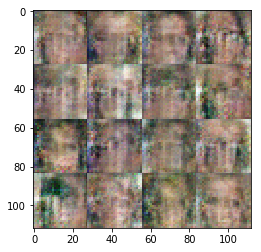

Epoch 0/1... Discriminator Loss: 0.0050... Generator Loss: 5.5660
Epoch 0/1... Discriminator Loss: 0.0011... Generator Loss: 7.7588
Epoch 0/1... Discriminator Loss: 0.0008... Generator Loss: 10.0086
Epoch 0/1... Discriminator Loss: 0.0120... Generator Loss: 5.4777
Epoch 0/1... Discriminator Loss: 0.0018... Generator Loss: 7.5822


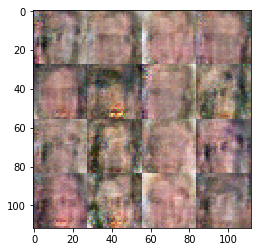

Epoch 0/1... Discriminator Loss: 0.0113... Generator Loss: 5.1743
Epoch 0/1... Discriminator Loss: 0.0022... Generator Loss: 7.0252
Epoch 0/1... Discriminator Loss: 0.0083... Generator Loss: 12.5480
Epoch 0/1... Discriminator Loss: 0.0017... Generator Loss: 8.6679
Epoch 0/1... Discriminator Loss: 0.0021... Generator Loss: 7.8271


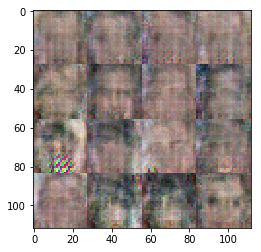

Epoch 0/1... Discriminator Loss: 0.0010... Generator Loss: 7.6671
Epoch 0/1... Discriminator Loss: 0.0074... Generator Loss: 7.8322


In [66]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.